In [86]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import uniform
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


import subprocess
print("\nLibrary versions from pip:")
libraries = ['pickle', 'pandas', 'matplotlib', 'numpy', 'scipy', 'scikit-learn', 'gensim']
for lib in libraries:
    version = subprocess.run(['pip', 'show', lib], capture_output=True, text=True)
    version_info = next((line for line in version.stdout.splitlines() if line.startswith("Version")), None)
    print(f"{lib}: {version_info}")



Library versions from pip:
pickle: None
pandas: Version: 2.2.3
matplotlib: Version: 3.9.3
numpy: Version: 1.26.4
scipy: Version: 1.13.1
scikit-learn: Version: 1.5.2
gensim: Version: 4.3.3


**fazer dois modelos com funcoes diferentes**

1. noticia vs nao noticia

    - tdidf

    - ~~word2vec~~

2. noticia de "topic" vs nao noticia de "topic" (**FUTURO**)

    - countAli (dicionario de contagem de palavras)

In [ ]:
df = pd.read_csv("newsClass.csv", index_col=0)

df1 = df[df["news"] == 1]
df0 = df[df["news"] == 0].sample(n=len(df1))
df = pd.concat([df1, df0])

print(df.value_counts("news"))

news
0    132
1    132
Name: count, dtype: int64


# tdidf + logreg

Train Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       108
           1       0.93      0.96      0.95       108

    accuracy                           0.94       216
   macro avg       0.95      0.94      0.94       216
weighted avg       0.95      0.94      0.94       216

Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        24
           1       0.92      0.92      0.92        24

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48



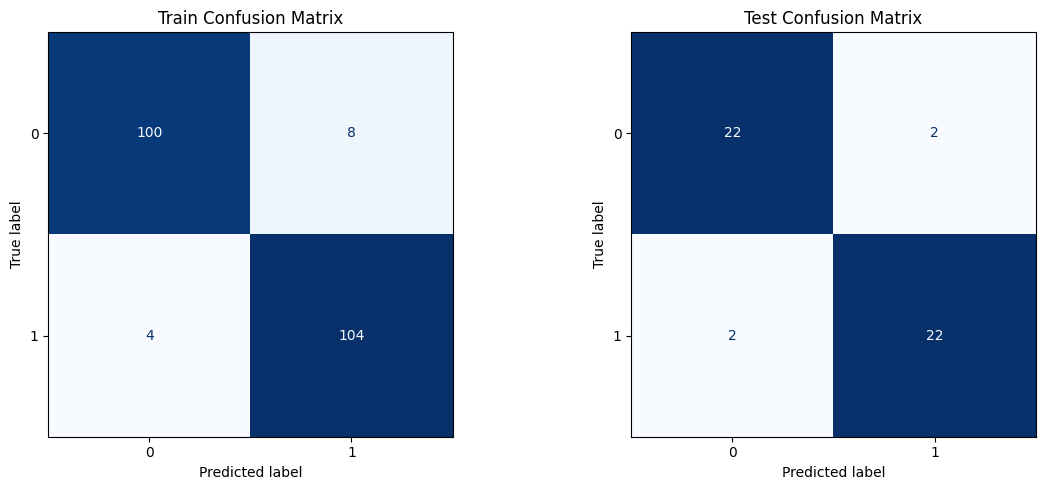

/opt/anaconda3/envs/condainfo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/condainfo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/condainfo/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/condainfo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1301, in fit


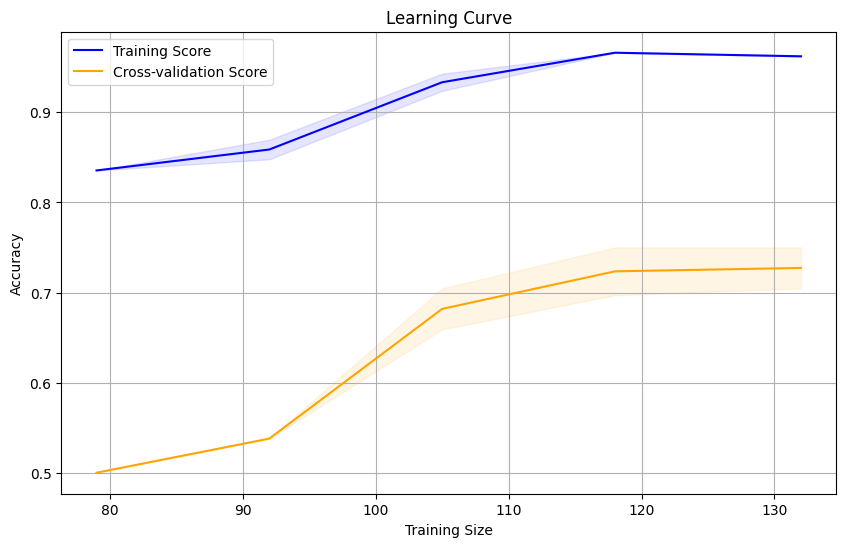

[[122  10]
 [  6 126]]


In [ ]:
# Preprocessing: TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = df['txt']
y = df["news"]

# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, stratify=y)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
X = vectorizer.transform(X)

model_TI = LogisticRegression(solver='saga', max_iter=10000)
recall_scorer = make_scorer(recall_score, pos_label=1)
param_distributions = {
    'C': uniform(loc=0.001, scale=30),  # Regularization strength (inverse of regularization)
    'penalty': ['l1', 'l2'],  # Regularization types
}
random_search = RandomizedSearchCV(
    estimator=model_TI,
    param_distributions=param_distributions,
    n_iter=100,      # Number of random samples
    cv=9,           # 7-fold cross-validation
    scoring=recall_scorer,
    random_state=42,
    n_jobs=-1       # Use all available processors
)
random_search.fit(X_train, y_train)

model_TI = random_search.best_estimator_
model_TI.fit(X_train, y_train)

# Predictions
y_train_pred = model_TI.predict(X_train)
y_test_pred = model_TI.predict(X_test)

# Classification Reports
print("Train Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrices
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

# Display Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(train_cm, display_labels=model_TI.classes_).plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("Train Confusion Matrix")

ConfusionMatrixDisplay(test_cm, display_labels=model_TI.classes_).plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("Test Confusion Matrix")

plt.tight_layout()
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    model_TI, X, y, cv=2, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes, test_mean, label='Cross-validation Score', color='orange')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='orange')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

print(confusion_matrix(y, model_TI.predict(X)))

# MODEL OK
"""
# Save the vectorizer and model to disk
with open("newsClass_tdidf_vecto.pkl", "wb") as vec_file:
    pickle.dump(vectorizer, vec_file)

with open("newsClass_tdidf_model.pkl", "wb") as model_file:
    pickle.dump(model_TI, model_file)
"""
""

In [70]:
"""df = pd.read_csv("../data/modelML.csv", index_col=0)

# Load the saved vectorizer and model
with open("vectorizer.pkl", "rb") as vec_file:
    loaded_vectorizer = pickle.load(vec_file)

with open("logistic_model.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

X = loaded_vectorizer.transform(df['txt'])
y = df["news"]

print(confusion_matrix(y, loaded_model.predict(X)))"""
""

''

# word2vec + logreg

Train Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       106
           1       0.76      0.83      0.79       105

    accuracy                           0.78       211
   macro avg       0.78      0.78      0.78       211
weighted avg       0.78      0.78      0.78       211

Test Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79        26
           1       0.81      0.78      0.79        27

    accuracy                           0.79        53
   macro avg       0.79      0.79      0.79        53
weighted avg       0.79      0.79      0.79        53



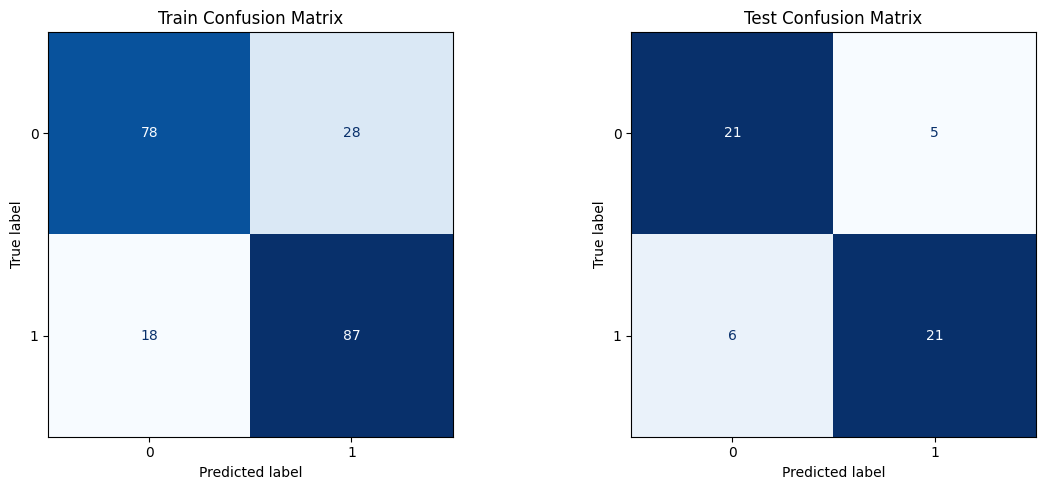

/opt/anaconda3/envs/condainfo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/condainfo/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/condainfo/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/condainfo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1301, in fit


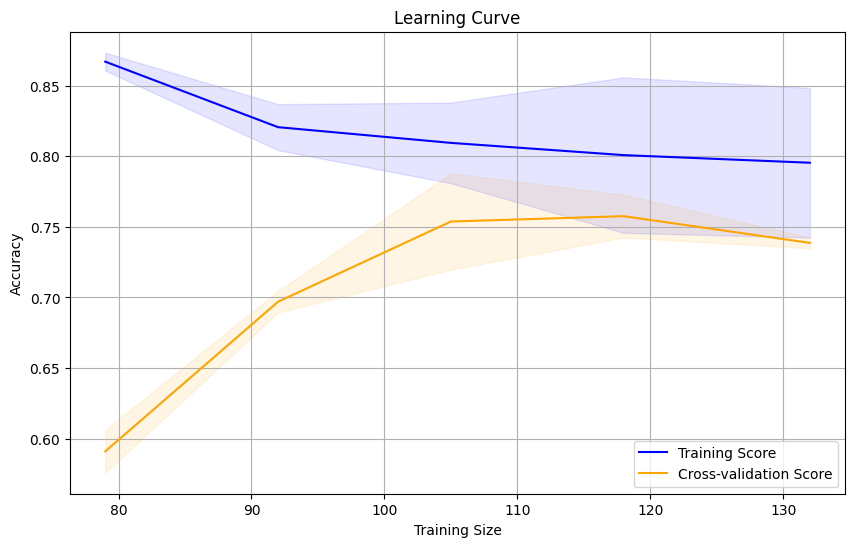

[[ 99  33]
 [ 24 108]]


In [ ]:
# Tokenize text (create a list of words for each document)
tokenized_text = [text.split() for text in df['txt']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=200, window=5, min_count=1, workers=5)

# Function to create document vectors by averaging Word2Vec word vectors
def create_word2vec_features(tokenized_text, model):
    features = []
    for words in tokenized_text:
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if word_vectors:  # If there are valid word vectors
            features.append(np.mean(word_vectors, axis=0))  # Average the vectors
        else:  # If no words in the document are in the vocabulary
            features.append(np.zeros(model.vector_size))  # Use a zero vector
    return np.array(features)

# Generate Word2Vec features
X = create_word2vec_features(tokenized_text, word2vec_model)
y = df['news']


# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)



model_WV = LogisticRegression(solver='saga', max_iter=10000)
recall_scorer = make_scorer(recall_score, pos_label=1)
param_distributions = {
    'C': uniform(loc=0.001, scale=50),  # Regularization strength (inverse of regularization)
    'penalty': ['l1', 'l2'],  # Regularization types
}
random_search = RandomizedSearchCV(
    estimator=model_WV,
    param_distributions=param_distributions,
    n_iter=100,      # Number of random samples
    cv=7,           # 7-fold cross-validation
    scoring=recall_scorer,
    random_state=42,
    n_jobs=-1       # Use all available processors
)
random_search.fit(X_train, y_train)

model_WV = random_search.best_estimator_
model_WV.fit(X_train, y_train)


# Predictions
y_train_pred = model_WV.predict(X_train)
y_test_pred = model_WV.predict(X_test)

# Classification Reports
print("Train Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrices
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

# Display Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(train_cm, display_labels=model_WV.classes_).plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("Train Confusion Matrix")

ConfusionMatrixDisplay(test_cm, display_labels=model_WV.classes_).plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("Test Confusion Matrix")

plt.tight_layout()
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    model_WV, X, y, cv=2, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes, test_mean, label='Cross-validation Score', color='orange')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='orange')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

print(confusion_matrix(y, model_WV.predict(X)))



# MODEL not so OK
"""
# Save Word2Vec model
#word2vec_model.save("newsClass_wrd2vec_wrd2vec.model")

 Save Logistic Regression model
#with open("newsClass_wrd2vec_model.pkl", "wb") as model_file:
#    pickle.dump(model_WV, model_file)
"""
#""